<h1 align="center">OpenMP part 2</h1> 

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [25]:
%%file convection_openmp.py

import numpy as np
from pyccel.epyccel import epyccel
from pyccel.stdlib.internal.openmp import omp_in_parallel,omp_get_thread_num, omp_get_num_threads

def threads_num():
    n = omp_get_num_threads()
    return n

def solve_2d_linearconv_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', c:'float'): 
    
    row, col = u.shape
    #$omp parallel 
    #$omp for
    for n in range(nt + 1):
        un[:] = u[:]
        row, col = u.shape
        #$omp for collapse(2)
        for j in range(1, row):
            for i in range(1, col):
                u[j, i] = (un[j, i] - (c * dt / dx * (un[j, i] - un[j, i - 1])) -
                                      (c * dt / dy * (un[j, i] - un[j - 1, i])))
                u[0, :] = 1
                u[-1, :] = 1
                u[:, 0] = 1
                u[:, -1] = 1
    #$omp end parallel   
    
    return 0



if __name__ == "__main__" :
    import time
        
    nx = 101
    ny = 101
    nt = 100
    c = 1.0
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    sigma = .2
    dt = sigma * dx

    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)

    u0 = np.ones((ny, nx))
    u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    u = u0.copy()
    un = np.ones((ny, nx))
    
    tcpu_0 = time.process_time()
    print(threads_num())
    solve_2d_linearconv_pyccel(u, un, nt, dt, dx, dy, c)
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0
    print("cpu time is ",tcpu)

Overwriting convection_openmp.py


In [27]:
import os
!pyccel --language=c convection_openmp.py --openmp

for num_threads in ["2", "4", "6", "8"]:
    os.environ["OMP_NUM_THREADS"] = num_threads
    !./convection_openmp
    print("\n")

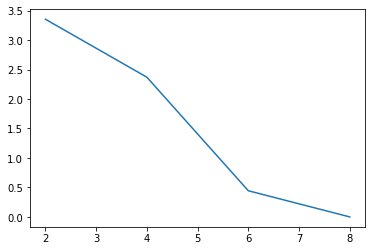

In [30]:
import matplotlib.pyplot as plt

threads = np.array([2,4, 6, 8])
cpu_time = np.array([3.353, 2.3702, 0.444, 0.0003])
plt.plot(threads,cpu_time)
plt.show()

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [2]:
def build_up_b(b : 'float[:,:]', rho : float, dt : float, u : 'float[:,:]', v : 'float[:,:]', dx : float, dy : float):
    import numpy
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

def pressure_poisson(p : 'float[:,:]', dx : float, dy : float, b : 'float[:,:]'):
    import numpy
    pn = numpy.empty_like(p)
    pn[:,:] = p[:,:]
    #$omp parallel
    #$omp for
    for q in range(nt):
        pn[:,:] = p[:,:]
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :] 
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
    #$omp end parallel   
    return p

def cavity_flow(nx : int, ny : int, nt : int, u : 'float[:,:]', v : 'float[:,:]', dt : float, dx : float, dy : float, p : 'float[:,:]', rho : float, nu : int):
    import numpy
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    #$omp parallel
    #$omp for
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        #$omp end parallel
        u[0, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        u[-1, :] = 1    # (velocity on cavity lid equal to 1)
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [4]:
def build_up_b_pyccel(b : 'float[:,:]', rho : float, dt : float, u : 'float[:,:]', v : 'float[:,:]', dx : float, dy : float):
    #$omp parallel
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    #$omp end parallel
    return 0
build_up_b = epyccel(build_up_b_pyccel,language = 'c',accelerators=['openmp'])



def pressure_poisson_pyccel(p : 'float[:,:]', dx : float, dy : float, b : 'float[:,:]',nit:int):
    import numpy as np
    pn = np.empty_like(p)
    pn[:,:] = p[:,:]
    #$omp parallel
    #$omp for
    for q in range(nit):
        pn[:,:] = p[:,:]
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
    
        p[:, -1] = p[:, -2] ##dp/dy = 0 at x = 2
        p[0, :] = p[1, :]  ##dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]    ##dp/dx = 0 at x = 0
        p[-1, :] = 0        ##p = 0 at y = 2
    #$omp end parallel    
    return 0
pressure_poisson = epyccel(pressure_poisson_pyccel,language = 'c',accelerators=['openmp'])


def cavity_flow_pyccel(nit:int,nx : int, ny : int,nt : int, u : 'float[:,:]', v : 'float[:,:]', dt : float, dx : float, dy : float, p : 'float[:,:]', rho : float, nu : int):
    import numpy as np
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    #$omp parallel
    #$omp for
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
        
        build_up_b(b, rho, dt, u, v, dx, dy)
        pressure_poisson(p, dx, dy, b,nit)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        #$omp end parallel
        u[0, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        u[-1, :] = 1    # (velocity on cavity lid equal to 1)
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
        
    return u, v, p

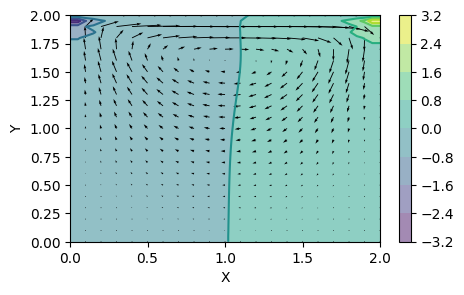

In [6]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1.0
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1.0
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_pyccel(nit,nx,ny,nt, u, v, dt, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y')
plt.show()